## Overview

1. Bagging
2. Boosting
3. Stacking
4. Ensemble vote classifier (mlxtend)

In [1]:
%matplotlib inline

import itertools
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

np.random.seed(0)

F:\Programming\Aanconda\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


# Bagging (多數決)

- parallel training
- majority vote
- reduce variance
- Most popular Bagging >> Random Forest

#### In random forests, each tree in the ensemble is built from a sample drawn with replacement (i.e. a bootstrap sample) from the training set. In addition, instead of using all the features, a random subset of features is selected further randomizing the tree. As a result, the bias of the forest increases slightly but due to averaging of less correlated trees, its variance decreases resulting in an overall better model.

#### Bagging stands for bootstrap aggregation. One way to reduce the variance of an estimate is to average together multiple estimates. For example, we can train $M$ different trees $f_m$ on different subsets of the data (chosen randomly with replacement) and compute the ensemble: $$
   f(x) = \frac{1}{M}\sum_{m=1}^{M}f_m(x) 
$$

Bagging uses bootstrap sampling to obtain the data subsets for training the base learners. For aggregating the outputs of base learners, bagging uses voting for classification and averaging for regression.

- k-NN are less sensitive to perturbation on training samples and therefore they are called stable learners.

- Combining stable learners is less advantageous since the ensemble will not help improve generalization performance.

In [2]:
iris = datasets.load_iris()

X,y = iris.data[:,0:2], iris.target

clf1 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 1)
clf2 = KNeighborsClassifier(n_neighbors = 1)

bagging1 = BaggingClassifier(base_estimator = clf1, n_estimators = 10, max_samples = 0.8, max_features = 0.8)
bagging2 = BaggingClassifier(base_estimator = clf2, n_estimators = 10, max_samples = 0.8, max_features = 0.8)

Accuracy: 0.63 (+/- 0.02) [Decision Tree]
Accuracy: 0.70 (+/- 0.02) [K-NN]
Accuracy: 0.67 (+/- 0.07) [Bagging Tree]
Accuracy: 0.68 (+/- 0.06) [Bagging K-NN]


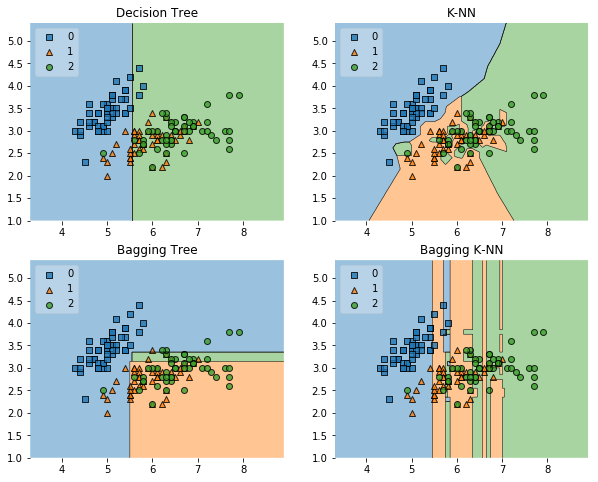

In [3]:
label = ['Decision Tree', 'K-NN', 'Bagging Tree', 'Bagging K-NN']
clf_list = [clf1, clf2, bagging1, bagging2]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)

plt.show()

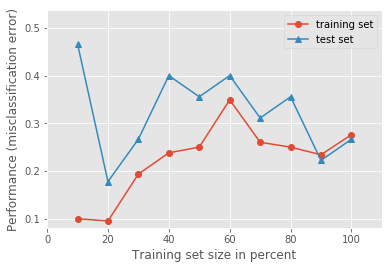

In [4]:
## plot learning curve

X_train, X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 42)

plt.figure()
plot_learning_curves(X_train,y_train,X_test,y_test,bagging1,print_model = False, style = 'ggplot')
plt.show()

In [5]:

#Ensemble Size
num_est = list(map(int, np.linspace(1,100,20)))
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:    
    bg_clf = BaggingClassifier(base_estimator=clf1, n_estimators=n_est, max_samples=0.8, max_features=0.8)
    scores = cross_val_score(bg_clf, X, y, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())
    

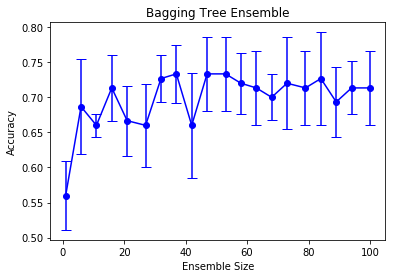

In [6]:

plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('Bagging Tree Ensemble');
plt.show()

# Boosting (強化法)

- Sequential model
- convert weak learners to strong learners (a little better than random guessing
)
- adjust weight for mis-classified data
- prediction were combined through a weighted majority vote


In [7]:
from sklearn.ensemble import AdaBoostClassifier

clf = DecisionTreeClassifier(criterion = 'entropy',max_depth = 1)

num_est = [1,2,3,10]

label = ['AdaBoost (n_est = 1)', 'AdaBoost (n_est = 2)','AdaBoost (n_est = 3)','AdaBoost(n_est = 10)']


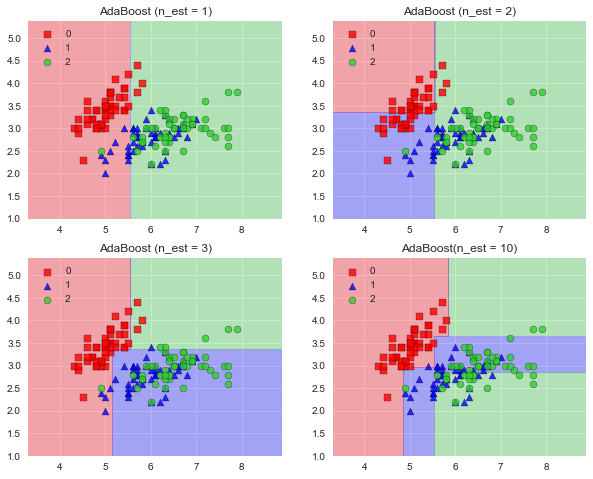

In [8]:
fig = plt.figure(figsize = (10,8))
gs = gridspec.GridSpec(2,2)
grid = itertools.product([0,1],repeat = 2)

for n_est, label, grd in zip(num_est,label,grid):
    boosting = AdaBoostClassifier(base_estimator = clf, n_estimators = n_est)
    boosting.fit(X,y)
    ax = plt.subplot(gs[grd[0],grd[1]])
    fig = plot_decision_regions(X = X,y = y,clf = boosting,legend = 2)
    plt.title(label)
    
plt.show()

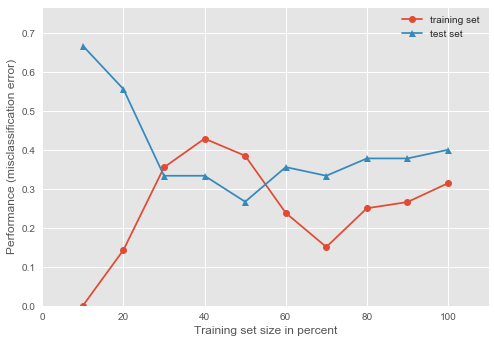

In [9]:
## plot learning curve

X_train, X_test, y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 0)

boosting = AdaBoostClassifier(base_estimator = clf,n_estimators = 10)

plt.figure()
plot_learning_curves(X_train,y_train,X_test,y_test,boosting, print_model = False,style = 'ggplot')
plt.show()

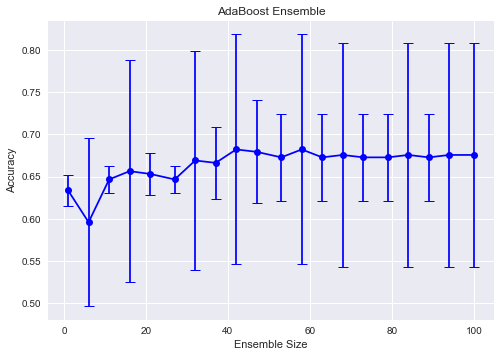

In [10]:
## Ensemble Size
num_est = list(map(int,np.linspace(1,100,20)))
bg_clf_cv_mean = []
bg_clf_cv_std = []

for n_est in num_est:
    ada_clf = AdaBoostClassifier(base_estimator = clf,n_estimators = n_est)
    scores = cross_val_score(ada_clf,X,y,cv = 3,scoring = 'accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())
plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('AdaBoost Ensemble');
plt.show()
    
    
    

               

# Stacking

#### Stacking is an ensemble learning technique that combines multiple classification or regression models via a meta-classifier or a meta-regressor. The base level models are trained based on complete training set then the meta-model is trained on the outputs of base level model as features. The base level often consists of different learning algorithms and therefore stacking ensembles are often heterogeneous.

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.91 (+/- 0.06) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [Naive Bayes]
Accuracy: 0.95 (+/- 0.03) [Stacking Classifier]


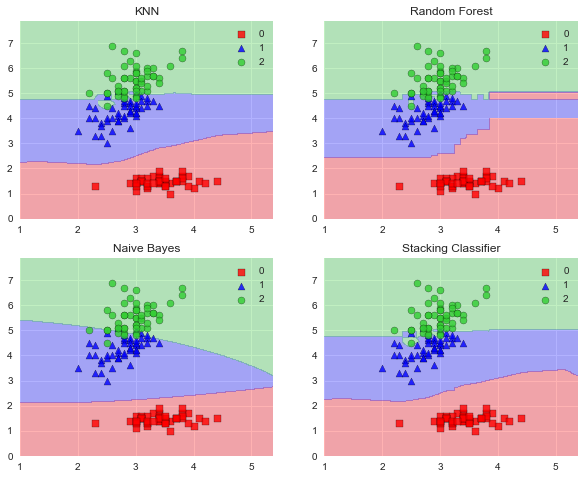

In [19]:
iris = datasets.load_iris()
X,y = iris.data[:,1:3], iris.target


clf1 = KNeighborsClassifier(n_neighbors = 1)
clf2 = RandomForestClassifier(random_state = 1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers = [clf1,clf2,clf3], meta_classifier = lr)


label = ['KNN', 'Random Forest', 'Naive Bayes', 'Stacking Classifier']
clf_list = [clf1, clf2, clf3, sclf]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, label, grid):
        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(label)

plt.show()
    


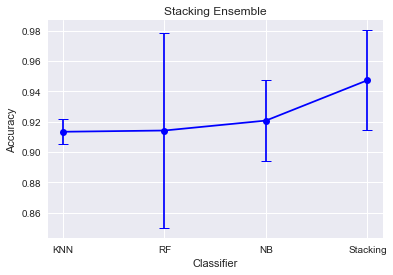

In [20]:

#plot classifier accuracy    
plt.figure()
(_, caps, _) = plt.errorbar(range(4), clf_cv_mean, yerr=clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.xticks(range(4), ['KNN', 'RF', 'NB', 'Stacking'])        
plt.ylabel('Accuracy'); plt.xlabel('Classifier'); plt.title('Stacking Ensemble');
plt.show()

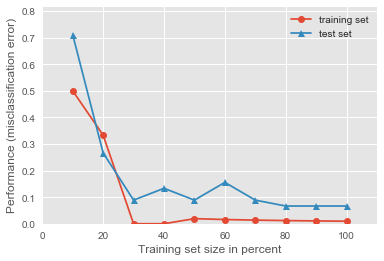

In [22]:
## plot learning curve
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 42)

plt.figure()
plot_learning_curves(X_train,y_train,X_test,y_test,sclf,print_model = False,style = 'ggplot')
plt.show()

## Ensemble Vote Classifier

- mlxtend for majority vote
- can assign different weight 


In [1]:
from mlxtend.data import iris_data
from mlxtend.classifier import EnsembleVoteClassifier

eclf = EnsembleVoteClassifier(clfs = [clf1,clf2,clf3], weights = [2,1,1],voting = 'soft')
X ,y = iris_data()
X = X[:,[0,2]]

## Plot decision regions

gs=  gridspec.GridSpec(2,2)
fig = plt.figure(figsize=(10,8))

labels = ['Logistic Regression',
         'Random Forest',
         'RBF kernel SVM',
         'Ensemble']

for clf, lab, grd in zip([clf1,clf2,clf3,eclf],
                        labels,
                        itertools.product([0,1],
                                         repeat=  2)):
    clf.fit(X,y)
    ax = plt.subplot(gs[grd[0],grd[1]])
    fig = plot_decision_regions(X = X,y= y,clf = clf,legend= 2)
    plt.title(lab)
    
plt.show()

F:\Programming\Aanconda\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


NameError: name 'clf1' is not defined